In [1]:
from typing import *
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
sns.set_context("notebook")

In [2]:
df = pd.concat([
    pd.read_json("../../out/2023-05-quantisation-4-8bit/4-8bit_refresh.jsonl", lines=True)
     .pipe(lambda d: d[d["model"].isin(['EleutherAI/pythia-410m', 'EleutherAI/pythia-1.4b'])]),
    pd.read_json("../../out/2023-05-quantisation-4-8bit/4-8bit_refresh_p2.jsonl", lines=True),
    pd.read_json("../../out/sweep_bits_v2.jsonl", lines=True),
]).reset_index()
df = df.rename(columns={
     c: dict(outcompare="oc", arc_easy="arc", lambada_openai="lam")[c.split(":")[0]] + "_" + c.split(":")[1]
     for c in df.columns
     if ":" in c})

def get_element_stats(d: Dict[str, Any]) -> Dict[str, Any]:
     if d["_type"] in ["fp", "ieee"]:
          return dict(
               element_dtype=f"E{d['exponent_bits']}M{d['mantissa_bits']}",
               element_dtype_kind=f"E{d['exponent_bits']}",
               element_dtype_bits=1 + d['exponent_bits'] + d['mantissa_bits'],
          )
     if d["_type"] == "int":
          return dict(
               element_dtype=f"E0M{d['bits_']-1}",
               element_dtype_kind="int",
               element_dtype_bits=d['bits_'],
          )
     if d["_type"] == "lut":
          return dict(
               element_dtype=f"LUT{int(np.log2(len(d['values'])))}[{d['name']}]",
               element_dtype_kind=d['name'],
               element_dtype_bits=int(np.log2(len(d["values"]))),
          )
     assert d["_type"] == "linear", d["_type"]
     return dict(
          get_element_stats(d["element_format"]),
          scale_combiner=d["scale_combiner"] or "none",
          group_size=min((g for group in d["group_shapes"] for g in group if g not in {1, None}), default=None),
     )

df["model"] = df["model"].apply(lambda s: s.split("/")[1])
df["compression"] = df["quantised_bytes"] / (2 * df["parameters"])
df = df.join(df["format"].apply(get_element_stats).apply(pd.Series))

print(f"{len(df)} rows")
print("models", df.model.unique())
df.tail()[["model", "format_name", "scale_combiner", "group_size", "oc_entropy_rmse", "oc_time"]]

494 rows
models ['pythia-410m' 'pythia-1.4b' 'pythia-2.8b' 'pythia-6.9b' 'opt-125m'
 'opt-1.3b' 'opt-2.7b']


,model,format_name,scale_combiner,group_size,oc_entropy_rmse,oc_time
489,opt-2.7b,LUT8[NF-approx]{1.32:E5M10},none,32.0,0.011151,1453.314437
490,opt-2.7b,LUT8[NF-approx]{1.64:E5M10},none,64.0,0.012495,1626.618043
491,opt-2.7b,LUT8[quad]{1.*:E5M10},none,NaN,0.015349,1826.225498
492,opt-2.7b,LUT8[quad]{1.32:E5M10},none,32.0,0.010774,1408.839753
493,opt-2.7b,LUT8[quad]{1.64:E5M10},none,64.0,0.011288,1446.743767


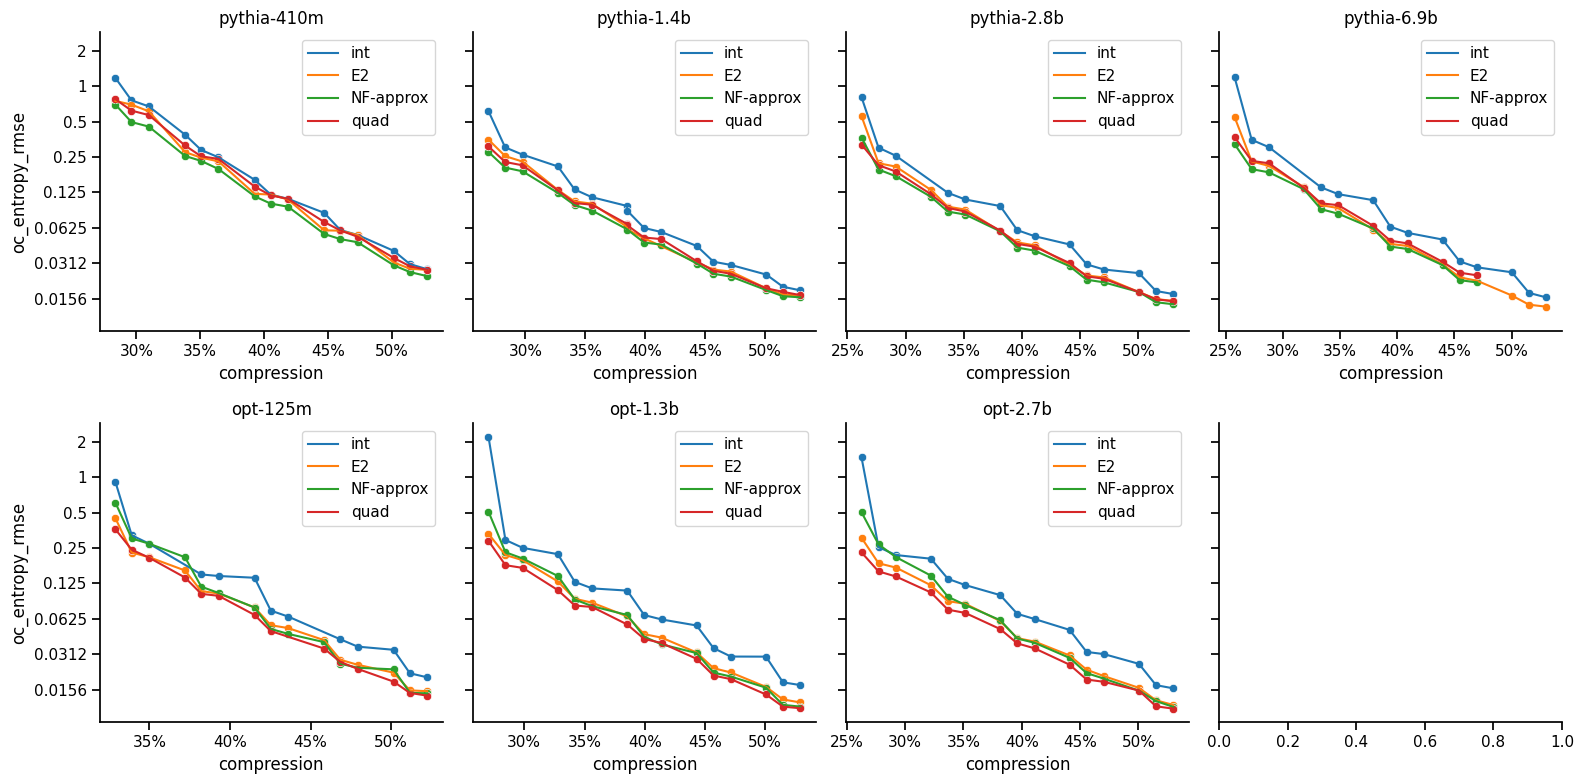

In [8]:
nmodels = len(set(df["model"]))
y = "oc_exact_match_length"; sign = -1
y = "oc_entropy_rmse"; sign = 1
for (model, gg), ax in zip(df.groupby("model", sort=False), plt.subplots(2, (nmodels+1)//2, figsize=(16, 8), sharey=True)[1].flatten()):
    for (kind, g), color in zip(gg.groupby("element_dtype_kind", sort=False), sns.color_palette()):
        d = g[g.apply(lambda s: ~((np.round(100*g["compression"]) <= np.round(100*s["compression"]))
                                   & (g[y]*sign < s[y]*sign)).any(), axis=1)]
        sns.lineplot(data=d, y=y, x="compression", color=color, ax=ax, label=kind)
        sns.scatterplot(data=d, y=y, x="compression", color=color, ax=ax)
        # for _, s in d.iterrows():
        #     ax.annotate(s["group_size"], [s["compression"], s[y]],
        #                 fontsize=5, ha="right", va="center", xytext=(-3, 0), textcoords="offset points",
        #                 rotation=sign*15, rotation_mode="anchor")
    ax.set_yscale("log", base=2)
    ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:.0%}"))
    ax.xaxis.set_minor_formatter(matplotlib.ticker.StrMethodFormatter("{x:.0%}"))
    ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:.3g}"))
    ax.legend(loc="lower right" if sign < 0 else "upper right")
    ax.set_title(model)
plt.tight_layout()
sns.despine()

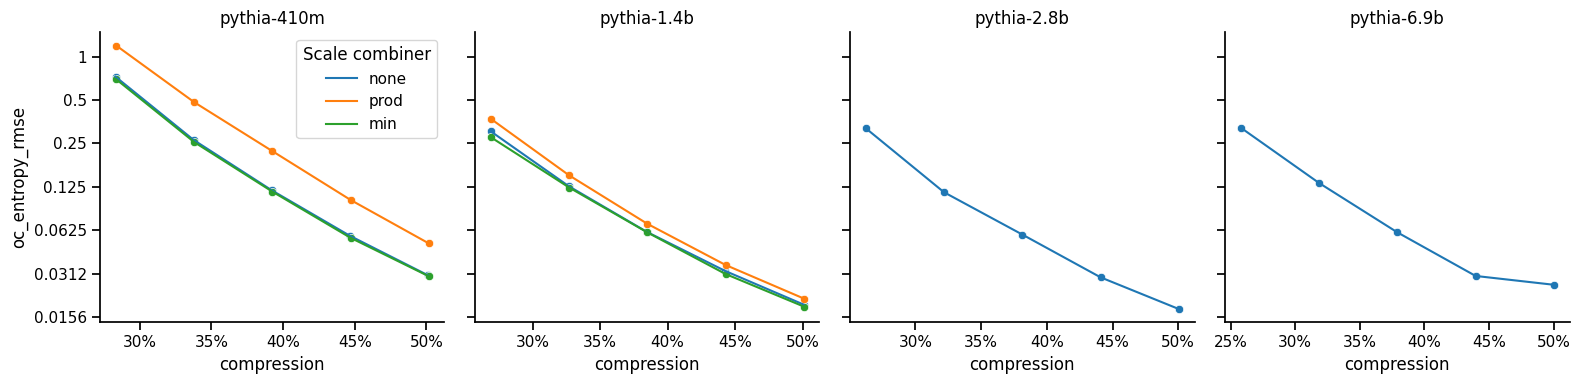

In [4]:
y = "oc_exact_match_length"; sign = -1
y = "oc_entropy_rmse"; sign = 1
for (model, gg), ax in zip(df[df["group_size"].isna()].groupby("model", sort=False), plt.subplots(1, nmodels, figsize=(4*nmodels, 4), sharey=True)[1]):
    for (kind, g), color in zip(gg.groupby("scale_combiner", sort=False), sns.color_palette()):
        d = g[g.apply(lambda s: ~((np.round(100*g["compression"]) <= np.round(100*s["compression"]))
                                   & (g[y]*sign < s[y]*sign)).any(), axis=1)]
        sns.lineplot(data=d, y=y, x="compression", color=color, ax=ax, label=kind)
        sns.scatterplot(data=d, y=y, x="compression", color=color, ax=ax)
    ax.set_yscale("log", base=2)
    ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:.0%}"))
    ax.xaxis.set_minor_formatter(matplotlib.ticker.StrMethodFormatter("{x:.0%}"))
    ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:.3g}"))
    if model == "pythia-410m":
        ax.legend(title="Scale combiner", loc="lower right" if sign < 0 else "upper right")
    else:
        ax.legend_.remove()
    ax.set_title(model)
plt.tight_layout()
sns.despine()